In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import optuna

import xgboost as xgb
xgb.set_config(verbosity=2)

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error


d:\github\RECSYS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train data `all_more`

In [2]:
df_train = pd.read_csv("../data/train_reviews_merged_all_more.csv")
df_train.sample(5)

,stars,useful,funny,cool,text,stars_neg,review_count_neg,is_open_neg,attributes_neg,categories_neg,review_count_user,average_stars_user,compliment_user
882936,5.0,0.595161,-0.150312,-0.251644,Amazing. Beautiful. Time takes back all desp...,4.5,1.240639,1,"{'GoodForKids': 'False', 'BusinessAcceptsCredi...","Religious Organizations, Local Services, Funer...",2.286915,3.83,-0.019349
136123,4.0,-0.062341,-0.150312,-0.251644,Great little spot near Vandy we stopped in for...,4.0,0.757461,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Greek, Mediterranean, Food, Ethnic Food, Middl...",1.991662,3.72,0.061755
667138,2.0,-0.391093,-0.150312,-0.251644,I absolutely love this place the food is great...,4.0,2.650570,1,"{'Caters': 'True', 'RestaurantsReservations': ...","Mexican, Restaurants",-0.042307,2.02,-0.035085
558316,5.0,0.266410,-0.150312,0.255613,"This place is recently under new management, a...",3.5,-0.240580,0,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Thai, Restaurants",-0.288352,4.50,-0.035085
494333,5.0,-0.391093,-0.150312,-0.251644,Love this place! This is our 4th time coming h...,4.5,7.078386,1,"{'Caters': 'True', 'BusinessParking': ""{'garag...","Sushi Bars, Japanese, Restaurants, Asian Fusio...",-0.288352,5.00,-0.035085


In [3]:
df_train.isnull().sum()

stars                 0
useful                0
funny                 0
cool                  0
text                  0
stars_neg             0
review_count_neg      0
is_open_neg           0
attributes_neg        0
categories_neg        0
review_count_user     0
average_stars_user    0
compliment_user       0
dtype: int64

Cogo lo que me interesa y no sea texto o target

In [4]:
X_numeric = df_train[["useful", "funny", "cool", "stars_neg", "review_count_neg", "review_count_user", "average_stars_user", "compliment_user",
                      "is_open_neg"]].copy()

X_numeric

,useful,funny,cool,stars_neg,review_count_neg,review_count_user,average_stars_user,compliment_user,is_open_neg
0,-0.391093,-0.150312,-0.251644,4.5,0.773303,-0.230941,4.08,-0.033875,1
1,0.266410,-0.150312,0.255613,2.5,-0.177212,-0.050509,2.89,-0.035085,1
2,-0.391093,-0.150312,-0.251644,2.5,-0.296027,-0.271949,3.75,-0.033875,1
3,-0.391093,-0.150312,-0.251644,4.5,0.226757,0.146327,3.79,-0.032664,0
4,2.896420,1.654029,3.299152,4.0,-0.105924,1.138707,4.20,0.004861,1
...,...,...,...,...,...,...,...,...,...
967779,-0.062341,-0.150312,-0.251644,4.5,0.812908,0.105320,4.58,-0.031454,0
967780,-0.391093,-0.150312,-0.251644,4.5,0.900038,1.417558,3.74,-0.030243,1
967781,-0.391093,-0.150312,0.255613,4.5,1.961447,-0.263747,4.20,-0.033875,1
967782,-0.391093,-0.150312,-0.251644,4.5,21.478689,-0.116121,4.70,-0.035085,1


In [5]:
X_numeric.isnull().sum()

useful                0
funny                 0
cool                  0
stars_neg             0
review_count_neg      0
review_count_user     0
average_stars_user    0
compliment_user       0
is_open_neg           0
dtype: int64

In [6]:
columns = ["text", "attributes_neg", "categories_neg"]

df_train[columns].sample(5)

,text,attributes_neg,categories_neg
118524,How are people comparing this place to Qdoba &...,"{'GoodForMeal': ""{'dessert': False, 'latenight...","Restaurants, Mexican, Fast Food"
400681,Great Museum! Located in Jackson Square next ...,"{'GoodForKids': 'True', 'WiFi': ""u'no'""}","Arts & Entertainment, Public Services & Govern..."
664263,I have been here multiple times. I usually ord...,"{'HappyHour': 'False', 'RestaurantsTableServic...","Japanese, Chinese, Sushi Bars, Restaurants"
781488,This is my first experience receiving a packag...,,"Couriers & Delivery Services, Local Services"
661803,R E Olds Park is a large 15 acre waterfront pa...,"{'GoodForKids': 'True', 'BikeParking': 'True',...","Local Flavor, Parks, Active Life, Playgrounds,..."


## Procesando texto de manera clásica

In [82]:
from scipy.sparse import hstack

# Aplicamos TfidfVectorizer en cada columna
tfidf_text = TfidfVectorizer(stop_words='english', max_features=15_000, ngram_range=(1, 2))
tfidf_attr = TfidfVectorizer(stop_words='english', max_features=7_500, ngram_range=(1, 2))
tfidf_cat  = TfidfVectorizer(stop_words='english', max_features=7_500, ngram_range=(1, 2))

X_text = tfidf_text.fit_transform(df_train['text'])
X_attr = tfidf_attr.fit_transform(df_train['attributes_neg'])
X_cat  = tfidf_cat.fit_transform(df_train['categories_neg'])

# Combinamos las matrices (cada una es una matriz dispersa)
X_combined = hstack([X_text, X_attr, X_cat])

svd = TruncatedSVD(n_components=50, random_state=42)
X_text_reduced = svd.fit_transform(X_text)

In [83]:
X_text_reduced.shape, X_numeric.shape, X_text.shape

((967784, 50), (967784, 9), (967784, 15000))

In [84]:
X_final = np.hstack([X_numeric.values, X_text_reduced])

y = df_train["stars"]

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((774227, 59), (193557, 59), (774227,), (193557,))

## Procesando texto DL

In [7]:
# Combinamos las matrices (cada una es una matriz dispersa)
X_text = np.load("../weight/embeddings_text_train_DL_all-mpnet-base-v2.npy")

svd = TruncatedSVD(n_components=150, n_iter=20, n_oversamples=4, random_state=42)
X_text_reduced = svd.fit_transform(X_text)

In [8]:
X_text_reduced.shape, X_numeric.shape, X_text.shape

((967784, 150), (967784, 9), (967784, 768))

In [9]:
X_final = np.hstack([X_numeric.values, X_text_reduced])

y = df_train["stars"]

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((774227, 159), (193557, 159), (774227,), (193557,))

In [12]:
np.save("final_stack.npy", X_final)

## RandomForestReg

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, verbose=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

In [ ]:
importances = rf.feature_importances_

numeric_feature_names = list(X_numeric.columns)
text_feature_names = [f"text_comp_{i+1}" for i in range(X_text_reduced.shape[1])]
feature_names = numeric_feature_names + text_feature_names

indices = np.argsort(importances)[::-1]

# Crear la gráfica
plt.figure(figsize=(12, 8))
plt.title("Importancia de las características")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

## HistGradientBoostingRegressor

In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(random_state=42, learning_rate=0.01, verbose=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

Binning 0.334 GB of training data: 0.458 s
Binning 0.037 GB of validation data: 0.030 s
Fitting gradient boosted rounds:
Fit 100 trees in 7.761 s, (3100 total leaves)
Time spent computing histograms: 5.310s
Time spent finding best splits:  0.234s
Time spent applying splits:      0.532s
Time spent predicting:           0.146s
MAE: 0.8606863429656669


## GradientBoostingRegressor

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=42, learning_rate=0.01, verbose=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

      Iter       Train Loss   Remaining Time 
         1           2.1710           38.69m
         2           2.1531           38.11m
         3           2.1355           37.62m
         4           2.1182           37.27m
         5           2.1013           36.81m
         6           2.0849           36.36m
         7           2.0685           35.97m
         8           2.0528           35.58m
         9           2.0370           35.20m
        10           2.0217           34.82m
        20           1.8810           32.45m
        30           1.7604           28.58m
        40           1.6572           24.20m
        50           1.5675           20.18m
        60           1.4896           16.26m
        70           1.4211           12.14m
        80           1.3607            8.05m
        90           1.3073            4.01m
       100           1.2604            0.00s
MAE: 0.938238277517477


## AdaBoostRegressor

In [27]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(random_state=42, learning_rate=0.001, n_estimators=4, 
                          estimator=RandomForestRegressor(n_estimators=50, random_state=42, verbose=1, n_jobs=-1))

ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.7min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.9

MAE: 0.5645549320941221


[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.4s finished


## XGBRegressor

In [10]:
xgboost = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
)

xgboost.fit(X_train, y_train, verbose=1)
y_pred = xgboost.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[14:35:03] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 159, 123102093).
MAE: 0.5184367227010693


## Stacking

In [10]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

estimators = [
    ('ada', AdaBoostRegressor(random_state=42, learning_rate=0.001, n_estimators=6, 
                          estimator=XGBRegressor(tree_method="hist", eval_metric=mean_absolute_error))),

    ('rf', RandomForestRegressor(n_estimators=50, random_state=42, verbose=1, n_jobs=-1)),

    ('xgb', XGBRegressor(tree_method="hist", eval_metric=mean_absolute_error)),
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    verbose=1
)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[15:08:16] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 159, 123102093).
[15:08:29] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 159, 123102093).
[15:08:40] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 159, 123102093).
[15:08:52] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 159, 123102093).
[15:09:04] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 159, 123102093).
[15:09:15] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 159, 123102093).


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 24.5min finished


[15:33:56] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 159, 123102093).
[15:34:08] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (619381, 159, 98481579).
[15:34:22] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (619381, 159, 98481579).
[15:34:33] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (619381, 159, 98481579).
[15:34:48] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (619381, 159, 98481579).
[15:34:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (619381, 159, 98481579).
[15:35:15] INFO: C:\actions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.6min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.6min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  9.0

[17:07:05] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (619381, 159, 98481579).
[17:07:16] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (619381, 159, 98481579).
[17:07:26] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (619382, 159, 98481738).
[17:07:36] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (619382, 159, 98481738).
[17:07:46] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (619382, 159, 98481738).


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s


MAE: 0.4957841627129702


[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.8s finished


In [14]:
import joblib

# Guardar el modelo entrenado
joblib.dump(stacking_model, 'stacking_model_0.4957.pkl')

['stacking_model_0.4957.pkl']

XGBoost

In [40]:
loaded_model = joblib.load('../weight/stacking_model_0.546.pkl')
loaded_model

StackingRegressor(estimators=[('ada',
                               AdaBoostRegressor(estimator=RandomForestRegressor(n_estimators=50,
                                                                                 n_jobs=-1,
                                                                                 random_state=42,
                                                                                 verbose=1),
                                                 learning_rate=0.001,
                                                 n_estimators=4,
                                                 random_state=42)),
                              ('rf',
                               RandomForestRegressor(n_estimators=50, n_jobs=-1,
                                                     random_state=42,
                                                     verbose=1)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_b...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                  final_estimator=LinearRegression(), verbose=1)

## VotingRegressor

In [ ]:
from sklearn.ensemble import VotingRegressor

xgboost = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
)

ada = AdaBoostRegressor(random_state=42, learning_rate=0.001, n_estimators=4, 
                          estimator=RandomForestRegressor(n_estimators=50, random_state=42, verbose=1, n_jobs=-1))

rf = RandomForestRegressor(n_estimators=50, random_state=42, verbose=1, n_jobs=-1)

er = VotingRegressor([('ada', ada), ('rf', rf), ('xgboost', xgboost)], n_jobs=-1)

er.fit(X_train, y_train)

VotingRegressor(estimators=[('ada',
                             AdaBoostRegressor(estimator=RandomForestRegressor(n_estimators=50,
                                                                               n_jobs=-1,
                                                                               random_state=42,
                                                                               verbose=1),
                                               learning_rate=0.001,
                                               n_estimators=4,
                                               random_state=42)),
                            ('rf',
                             RandomForestRegressor(n_estimators=50, n_jobs=-1,
                                                   random_state=42,
                                                   verbose=1)),
                            ('xgboost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample...
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...))],
                n_jobs=-1)

In [48]:
y_pred = er.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0

MAE: 0.5514425473709493


[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.5s finished


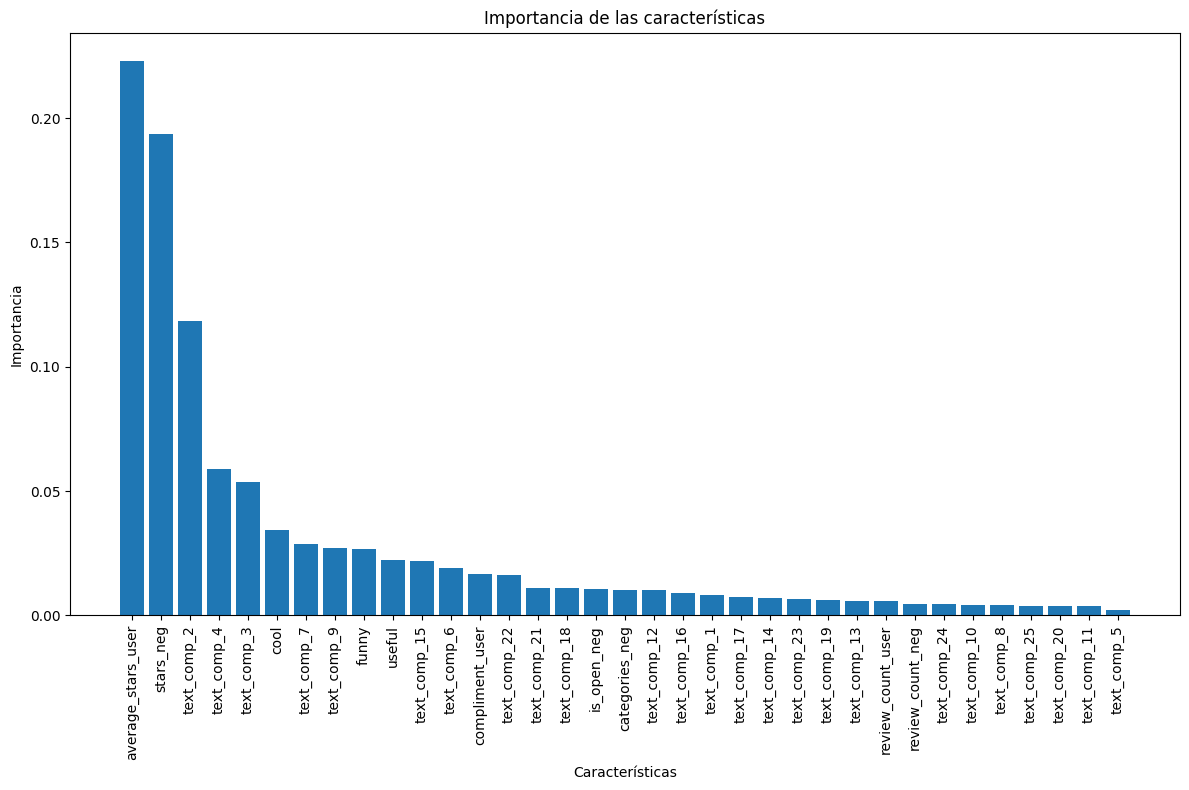

In [ ]:
importances = reg.feature_importances_

numeric_feature_names = list(X_numeric.columns)
text_feature_names = [f"text_comp_{i+1}" for i in range(X_text_reduced.shape[1])]
feature_names = numeric_feature_names + text_feature_names

indices = np.argsort(importances)[::-1]

# Crear la gráfica
plt.figure(figsize=(12, 8))
plt.title("Importancia de las características")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

# Test models

In [11]:
# Ahora, procesar el conjunto de test (sin ajustar de nuevo el vectorizador ni el SVD)
df_test = pd.read_csv('../data/test_reviews_merged_all_more.csv')

Y_numeric = df_test[["useful", "funny", "cool", "stars_neg", "review_count_neg", "review_count_user", "average_stars_user", "compliment_user"]].copy()
Y_numeric["is_open_neg"] = df_test["is_open_neg"].astype(int)

Y_numeric

,useful,funny,cool,stars_neg,review_count_neg,review_count_user,average_stars_user,compliment_user,is_open_neg
0,-0.063127,-0.164229,0.253789,4.5,1.375296,-0.001300,4.11,-0.032664,1
1,0.917552,-0.164229,0.759641,4.0,0.583200,0.679424,3.77,0.152543,1
2,0.263766,-0.164229,-0.252063,3.5,0.765382,-0.107919,2.92,-0.031454,1
3,0.263766,-0.164229,-0.252063,4.0,1.256481,0.269349,3.82,0.026650,1
4,-0.390020,-0.164229,-0.252063,2.5,3.561480,-0.271949,1.25,-0.033875,1
...,...,...,...,...,...,...,...,...,...
414760,-0.390020,-0.164229,-0.252063,4.0,15.997386,2.057274,3.53,0.042387,1
414761,-0.390020,-0.164229,-0.252063,4.0,-0.288106,-0.271949,5.00,-0.035085,1
414762,-0.390020,-0.164229,-0.252063,3.5,2.777305,2.409938,3.88,0.025440,0
414763,0.917552,-0.164229,0.253789,4.5,1.304007,2.951236,4.06,0.019387,0


In [12]:
Y_text = np.load("../weight/embeddings_text_test_DL_all-mpnet-base-v2.npy")

svd = TruncatedSVD(n_components=150, n_iter=20, n_oversamples=4, random_state=42)
Y_text_test_svd = svd.fit_transform(Y_text)

X_test = np.hstack([Y_numeric.values, Y_text_test_svd])

predictions = stacking_model.predict(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    1.8s finished


## CSV

In [13]:
# Crear el DataFrame con el formato requerido: review_id, stars
df_output = pd.DataFrame({
    'review_id': df_test['review_id'],
    'stars': predictions.round(0)
})

# Exportar el CSV con las predicciones
df_output.to_csv('stacking_model_model_predictions_all_0_DL.csv', index=False)
print("Predicciones exportadas a 'xgboost_model_predictions_all_0_DL.csv'")

Predicciones exportadas a 'xgboost_model_predictions_all_0_DL.csv'


# Hiperparámetros

## Reduccion dimensional (TruncatedSVD)

In [ ]:
def objective(trial):
    # Sugerencias para TruncatedSVD
    n_components = trial.suggest_int('n_components', 20, 200, step=5)
    n_iter = trial.suggest_int('n_iter', 5, 20, step=5)
    n_oversamples = trial.suggest_int('n_oversamples', 2, 8, step = 1)

    print(f"Trial {trial.number} - n_components: {n_components}, n_iter: {n_iter}, n_oversamples: {n_oversamples}")

    # Cargamos los embeddings precomputados
    X_text = np.load("../weight/embeddings_text_train_DL_all-mpnet-base-v2.npy")

    # Creamos el TruncatedSVD con los hiperparámetros sugeridos
    svd = TruncatedSVD(
        n_components=n_components,
        n_iter=n_iter,
        n_oversamples=n_oversamples,
        random_state=42
    )
    X_text_reduced = svd.fit_transform(X_text)
    
    # Combinamos con otras características numéricas
    X_final = np.hstack([X_numeric.values, X_text_reduced])
    
    y = df_train["stars"]
    X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

    # Entrenamos el modelo XGBoost
    reg = XGBRegressor(
        tree_method="hist",
        eval_metric=mean_absolute_error,
        random_state=42,
    )
    reg.fit(X_train, y_train, verbose=False)
    y_pred = reg.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"Trial {trial.number} - MAE: {mae}\n")
    return mae

In [11]:
# Creamos y ejecutamos el estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Mejores hiperparámetros encontrados:", study.best_trial.params)
print("Mejor MAE:", study.best_value)

[I 2025-04-13 13:12:27,242] A new study created in memory with name: no-name-e863853c-c69d-4051-906a-1e949f57f575


Trial 0 - n_components: 125, n_iter: 10, n_oversamples: 8
[13:13:20] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 134, 103746418).
Trial 0 - MAE: 0.5198457555800627



[I 2025-04-13 13:13:28,864] Trial 0 finished with value: 0.5198457555800627 and parameters: {'n_components': 125, 'n_iter': 10, 'n_oversamples': 8}. Best is trial 0 with value: 0.5198457555800627.


Trial 1 - n_components: 115, n_iter: 15, n_oversamples: 5
[13:14:29] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 124, 96004148).


[I 2025-04-13 13:14:35,923] Trial 1 finished with value: 0.5209107322448631 and parameters: {'n_components': 115, 'n_iter': 15, 'n_oversamples': 5}. Best is trial 0 with value: 0.5198457555800627.


Trial 1 - MAE: 0.5209107322448631

Trial 2 - n_components: 40, n_iter: 15, n_oversamples: 8
[13:15:04] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 49, 37937123).


[I 2025-04-13 13:15:07,440] Trial 2 finished with value: 0.5232984505177074 and parameters: {'n_components': 40, 'n_iter': 15, 'n_oversamples': 8}. Best is trial 0 with value: 0.5198457555800627.


Trial 2 - MAE: 0.5232984505177074

Trial 3 - n_components: 90, n_iter: 5, n_oversamples: 7
[13:15:33] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 99, 76648473).
Trial 3 - MAE: 0.5205579754880189



[I 2025-04-13 13:15:38,380] Trial 3 finished with value: 0.5205579754880189 and parameters: {'n_components': 90, 'n_iter': 5, 'n_oversamples': 7}. Best is trial 0 with value: 0.5198457555800627.


Trial 4 - n_components: 120, n_iter: 20, n_oversamples: 6
[13:16:56] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 129, 99875283).
Trial 4 - MAE: 0.5206016598283508



[I 2025-04-13 13:17:03,250] Trial 4 finished with value: 0.5206016598283508 and parameters: {'n_components': 120, 'n_iter': 20, 'n_oversamples': 6}. Best is trial 0 with value: 0.5198457555800627.


Trial 5 - n_components: 150, n_iter: 20, n_oversamples: 4
[13:18:44] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 159, 123102093).
Trial 5 - MAE: 0.5184367227010693



[I 2025-04-13 13:18:53,768] Trial 5 finished with value: 0.5184367227010693 and parameters: {'n_components': 150, 'n_iter': 20, 'n_oversamples': 4}. Best is trial 5 with value: 0.5184367227010693.


Trial 6 - n_components: 85, n_iter: 10, n_oversamples: 2
[13:19:30] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 94, 72777338).
Trial 6 - MAE: 0.5214788320188524



[I 2025-04-13 13:19:35,275] Trial 6 finished with value: 0.5214788320188524 and parameters: {'n_components': 85, 'n_iter': 10, 'n_oversamples': 2}. Best is trial 5 with value: 0.5184367227010693.


Trial 7 - n_components: 140, n_iter: 5, n_oversamples: 2
[13:20:12] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 149, 115359823).
Trial 7 - MAE: 0.5199901741814075



[I 2025-04-13 13:20:21,543] Trial 7 finished with value: 0.5199901741814075 and parameters: {'n_components': 140, 'n_iter': 5, 'n_oversamples': 2}. Best is trial 5 with value: 0.5184367227010693.


Trial 8 - n_components: 20, n_iter: 20, n_oversamples: 8
[13:20:45] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 29, 22452583).


[I 2025-04-13 13:20:47,344] Trial 8 finished with value: 0.5311643746126996 and parameters: {'n_components': 20, 'n_iter': 20, 'n_oversamples': 8}. Best is trial 5 with value: 0.5184367227010693.


Trial 8 - MAE: 0.5311643746126996

Trial 9 - n_components: 30, n_iter: 10, n_oversamples: 7
[13:21:06] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 39, 30194853).


[I 2025-04-13 13:21:09,272] Trial 9 finished with value: 0.5252013537181056 and parameters: {'n_components': 30, 'n_iter': 10, 'n_oversamples': 7}. Best is trial 5 with value: 0.5184367227010693.


Trial 9 - MAE: 0.5252013537181056

Trial 10 - n_components: 200, n_iter: 20, n_oversamples: 4
[13:23:10] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 209, 161813443).
Trial 10 - MAE: 0.5198603234565662



[I 2025-04-13 13:23:22,403] Trial 10 finished with value: 0.5198603234565662 and parameters: {'n_components': 200, 'n_iter': 20, 'n_oversamples': 4}. Best is trial 5 with value: 0.5184367227010693.


Trial 11 - n_components: 155, n_iter: 10, n_oversamples: 4
[13:24:23] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 164, 126973228).
Trial 11 - MAE: 0.5203944753399932



[I 2025-04-13 13:24:32,944] Trial 11 finished with value: 0.5203944753399932 and parameters: {'n_components': 155, 'n_iter': 10, 'n_oversamples': 4}. Best is trial 5 with value: 0.5184367227010693.


Trial 12 - n_components: 175, n_iter: 15, n_oversamples: 4
[13:26:01] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 184, 142457768).
Trial 12 - MAE: 0.5194179733133866



[I 2025-04-13 13:26:12,525] Trial 12 finished with value: 0.5194179733133866 and parameters: {'n_components': 175, 'n_iter': 15, 'n_oversamples': 4}. Best is trial 5 with value: 0.5184367227010693.


Trial 13 - n_components: 180, n_iter: 15, n_oversamples: 4
[13:27:43] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 189, 146328903).
Trial 13 - MAE: 0.51935621429236



[I 2025-04-13 13:27:53,557] Trial 13 finished with value: 0.51935621429236 and parameters: {'n_components': 180, 'n_iter': 15, 'n_oversamples': 4}. Best is trial 5 with value: 0.5184367227010693.


Trial 14 - n_components: 180, n_iter: 20, n_oversamples: 3
[13:29:47] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 189, 146328903).
Trial 14 - MAE: 0.520653715922718



[I 2025-04-13 13:29:59,136] Trial 14 finished with value: 0.520653715922718 and parameters: {'n_components': 180, 'n_iter': 20, 'n_oversamples': 3}. Best is trial 5 with value: 0.5184367227010693.


Trial 15 - n_components: 160, n_iter: 15, n_oversamples: 5
[13:31:21] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 169, 130844363).
Trial 15 - MAE: 0.5199506574970512



[I 2025-04-13 13:31:31,310] Trial 15 finished with value: 0.5199506574970512 and parameters: {'n_components': 160, 'n_iter': 15, 'n_oversamples': 5}. Best is trial 5 with value: 0.5184367227010693.


Trial 16 - n_components: 200, n_iter: 20, n_oversamples: 3
[13:33:30] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 209, 161813443).
Trial 16 - MAE: 0.5201960408847971



[I 2025-04-13 13:33:41,512] Trial 16 finished with value: 0.5201960408847971 and parameters: {'n_components': 200, 'n_iter': 20, 'n_oversamples': 3}. Best is trial 5 with value: 0.5184367227010693.


Trial 17 - n_components: 145, n_iter: 15, n_oversamples: 3
[13:34:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 154, 119230958).
Trial 17 - MAE: 0.5195469334314903



[I 2025-04-13 13:35:07,963] Trial 17 finished with value: 0.5195469334314903 and parameters: {'n_components': 145, 'n_iter': 15, 'n_oversamples': 3}. Best is trial 5 with value: 0.5184367227010693.


Trial 18 - n_components: 170, n_iter: 20, n_oversamples: 6
[13:36:56] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 179, 138586633).
Trial 18 - MAE: 0.5203429024028773



[I 2025-04-13 13:37:06,198] Trial 18 finished with value: 0.5203429024028773 and parameters: {'n_components': 170, 'n_iter': 20, 'n_oversamples': 6}. Best is trial 5 with value: 0.5184367227010693.


Trial 19 - n_components: 85, n_iter: 15, n_oversamples: 4
[13:37:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 94, 72777338).
Trial 19 - MAE: 0.5216007416682241



[I 2025-04-13 13:38:00,768] Trial 19 finished with value: 0.5216007416682241 and parameters: {'n_components': 85, 'n_iter': 15, 'n_oversamples': 4}. Best is trial 5 with value: 0.5184367227010693.


Trial 20 - n_components: 185, n_iter: 20, n_oversamples: 5
[13:39:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 194, 150200038).
Trial 20 - MAE: 0.5198920885675646



[I 2025-04-13 13:40:05,894] Trial 20 finished with value: 0.5198920885675646 and parameters: {'n_components': 185, 'n_iter': 20, 'n_oversamples': 5}. Best is trial 5 with value: 0.5184367227010693.


Trial 21 - n_components: 180, n_iter: 15, n_oversamples: 4
[13:41:37] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 189, 146328903).
Trial 21 - MAE: 0.51935621429236



[I 2025-04-13 13:41:46,852] Trial 21 finished with value: 0.51935621429236 and parameters: {'n_components': 180, 'n_iter': 15, 'n_oversamples': 4}. Best is trial 5 with value: 0.5184367227010693.


Trial 22 - n_components: 140, n_iter: 15, n_oversamples: 3
[13:43:02] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 149, 115359823).
Trial 22 - MAE: 0.5204974959620662



[I 2025-04-13 13:43:10,590] Trial 22 finished with value: 0.5204974959620662 and parameters: {'n_components': 140, 'n_iter': 15, 'n_oversamples': 3}. Best is trial 5 with value: 0.5184367227010693.


Trial 23 - n_components: 190, n_iter: 15, n_oversamples: 5
[13:44:42] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 199, 154071173).


[I 2025-04-13 13:44:53,538] Trial 23 finished with value: 0.5198881933739525 and parameters: {'n_components': 190, 'n_iter': 15, 'n_oversamples': 5}. Best is trial 5 with value: 0.5184367227010693.


Trial 23 - MAE: 0.5198881933739525

Trial 24 - n_components: 160, n_iter: 10, n_oversamples: 4
[13:45:54] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 169, 130844363).
Trial 24 - MAE: 0.5198766873973832



[I 2025-04-13 13:46:03,622] Trial 24 finished with value: 0.5198766873973832 and parameters: {'n_components': 160, 'n_iter': 10, 'n_oversamples': 4}. Best is trial 5 with value: 0.5184367227010693.


Trial 25 - n_components: 170, n_iter: 15, n_oversamples: 6
[13:47:29] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 179, 138586633).
Trial 25 - MAE: 0.5195551463098208



[I 2025-04-13 13:47:38,859] Trial 25 finished with value: 0.5195551463098208 and parameters: {'n_components': 170, 'n_iter': 15, 'n_oversamples': 6}. Best is trial 5 with value: 0.5184367227010693.


Trial 26 - n_components: 130, n_iter: 20, n_oversamples: 3
[13:49:10] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 139, 107617553).
Trial 26 - MAE: 0.5192138864666965



[I 2025-04-13 13:49:17,657] Trial 26 finished with value: 0.5192138864666965 and parameters: {'n_components': 130, 'n_iter': 20, 'n_oversamples': 3}. Best is trial 5 with value: 0.5184367227010693.


Trial 27 - n_components: 105, n_iter: 20, n_oversamples: 2
[13:50:26] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 114, 88261878).
Trial 27 - MAE: 0.5212342733067544



[I 2025-04-13 13:50:32,939] Trial 27 finished with value: 0.5212342733067544 and parameters: {'n_components': 105, 'n_iter': 20, 'n_oversamples': 2}. Best is trial 5 with value: 0.5184367227010693.


Trial 28 - n_components: 140, n_iter: 20, n_oversamples: 3
[13:52:08] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 149, 115359823).
Trial 28 - MAE: 0.5195847145778667



[I 2025-04-13 13:52:16,493] Trial 28 finished with value: 0.5195847145778667 and parameters: {'n_components': 140, 'n_iter': 20, 'n_oversamples': 3}. Best is trial 5 with value: 0.5184367227010693.


Trial 29 - n_components: 130, n_iter: 20, n_oversamples: 3
[13:53:48] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 139, 107617553).
Trial 29 - MAE: 0.5192138864666965



[I 2025-04-13 13:53:56,539] Trial 29 finished with value: 0.5192138864666965 and parameters: {'n_components': 130, 'n_iter': 20, 'n_oversamples': 3}. Best is trial 5 with value: 0.5184367227010693.


Mejores hiperparámetros encontrados: {'n_components': 150, 'n_iter': 20, 'n_oversamples': 4}
Mejor MAE: 0.5184367227010693


## Reduccion dimensional (PCA)

In [ ]:
def objective(trial):
    n_components = trial.suggest_int('n_components', 20, 200, step=5)

    print(f"Trial {trial.number} - max_componets: {n_components}")

    X_text = np.load("../weight/embeddings_text_train_DL_all-mpnet-base-v2.npy")

    svd = PCA(n_components=n_components, random_state=42)
    X_text_reduced = svd.fit_transform(X_text)  
    
    X_final = np.hstack([X_numeric.values, X_text_reduced])
    
    y = df_train["stars"]
    
    X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

    # Entrenamos el modelo XGBoost
    reg = XGBRegressor(
        tree_method="hist",
        eval_metric=mean_absolute_error,
        random_state=42,
    )
    reg.fit(X_train, y_train, verbose=False)
    y_pred = reg.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Imprimimos el MAE obtenido para esta prueba
    print(f"Trial {trial.number} - MAE: {mae}\n")
    return mae

## XGBoost

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import optuna
from xgboost import XGBRegressor

import xgboost as xgb
xgb.set_config(verbosity=0)

def objective(trial):
    # Cargamos las características y la variable objetivo
    X_final = np.load("../weight/final_stack_XGBoost.npy")
    y = df_train["stars"]
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y, test_size=0.2, random_state=42
    )
    
    # Mapeo para parámetros categóricos
    booster_options = {1: "gbtree", 2: "gblinear", 3: "dart"}
    tree_method_options = {1: "auto", 2: "exact", 3: "hist"}
    grow_policy_options = {1: "depthwise", 2: "lossguide"}
    
    booster_idx = trial.suggest_int("booster_idx", 1, 3)
    tree_method_idx = trial.suggest_int("tree_method_idx", 1, 3)
    grow_policy_idx = trial.suggest_int("grow_policy_idx", 1, 2)
    
    booster = booster_options[booster_idx]
    tree_method = tree_method_options[tree_method_idx]
    grow_policy = grow_policy_options[grow_policy_idx]
    
    # Parámetros numéricos actualizados
    eta = trial.suggest_float("eta", 1e-3, 0.7, log=True)
    gamma = trial.suggest_float("gamma", 0.0, 10.0)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    min_child_weight = trial.suggest_float("min_child_weight", 1, 5)
    max_delta_step = trial.suggest_float("max_delta_step", 0, 5)
    subsample = trial.suggest_float("subsample", 0.2, 1.0)
    reg_lambda = trial.suggest_float("lambda", 1e-3, 10.0, log=True)
    alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
    scale_pos_weight = trial.suggest_float("scale_pos_weight", 0.5, 5)
    max_leaves = trial.suggest_int("max_leaves", 1, 10)
    max_bin = trial.suggest_int("max_bin", 125, 525, step=25)
    
    params = {
        "booster": booster,
        "tree_method": tree_method,
        "grow_policy": grow_policy,
        "eta": eta,
        "gamma": gamma,
        "max_depth": max_depth,
        "min_child_weight": min_child_weight,
        "max_delta_step": max_delta_step,
        "subsample": subsample,
        "reg_lambda": reg_lambda,
        "alpha": alpha,
        "scale_pos_weight": scale_pos_weight,
        "max_leaves": max_leaves,
        "max_bin": max_bin,
        "random_state": 42,
        "eval_metric": "mae"
    }
    
    print(f"Trial {trial.number} parameters: {params}")
    
    # Entrenamos el modelo
    reg = XGBRegressor(**params)
    reg.fit(X_train, y_train, verbose=False)
    y_pred = reg.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"Trial {trial.number} - MAE: {mae}\n")
    return mae

# Para iniciar el estudio:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

In [ ]:
print("Best trial:")
trial = study.best_trial
print(trial.params)
print(f"Best MAE: {trial.value}")